## Part 1: Inference without finetuning

In [1]:
#loading packages
!pip install transformers -qq
!pip install huggingface_hub -qq
!pip install datasets -qq
!pip install accelerate -qq
!pip install evaluate -qq



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.4 MB/s eta 0:00:00


In [2]:
#Loading hte TinyStories Model
import torch
from datasets import load_dataset
from transformers import pipeline, logging

logging.set_verbosity_error()

torch.cuda.set_device(0)

model_name="Roneneldan/TinyStories-Instruct-33M"

pipe = pipeline(
    "text-generation",
    model=model_name,
    device_map="auto",
    trust_remote_code=True

)

config.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/291M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [3]:
#Run inference on TinyStories Model

prompt = """
Summary: Lily and Timmy build a sandcastle together and learn to compromise, but it gets knocked over by a gust of wind.
They find beauty in the broken sandcastle and play happily with a butterfly.
Features: Dialogue, Foreshadowing, Twist
Sentence: One day, she went to the park and saw a beautiful butterfly.
Words: disagree, network, beautiful
Story: """

output = pipe(
    prompt,
    max_new_tokens=200,
    do_sample=True,
    temperature=0.3,
    return_full_text=False
)

print(output[0]['generated_text'])



Possible story:

Lily and Timmy were best friends. They liked to play with blocks and dolls and cars. One day, they decided to build a big castle with towers and walls and a flag. They worked hard and used all their blocks and dolls. They were very proud of their castle.

"Look at our castle!" Lily said. "It is so beautiful. We are the king and the queen of the castle."

"Yes, we are!" Timmy agreed. "But we need more blocks. Can we go to the store?"

Lily and Timmy looked around. They saw a big box of blocks in the corner. They ran to the box and picked up some blocks. They were very happy.

"Let's make the castle bigger!" Lily said.

"OK!" Timmy said.

They started to build the castle with the blocks. They made walls and towers and a flag. They


In [4]:
prompt = "What color is an apple"

output = pipe(
    prompt,
    max_new_tokens=200,
    do_sample=True,
    temperature=0.5,
    return_full_text=False
)

print(output[0]['generated_text'])

?" Her mommy said, "It's a red apple. It's very yummy!" 

Lily was so excited to eat the apple that she almost forgot to say thank you to the man. She took a big bite and said, "Mmm, this is so good!" Her mommy smiled and said, "I'm glad you like it, Lily. Maybe we can come back to this restaurant again sometime."



In [5]:
prompt = "What color is an mango? Respond with one word"

output = pipe(
    prompt,
    max_new_tokens=10,
    do_sample=True,
    temperature=0.5,
    return_full_text=False
)

print(output[0]['generated_text'])

?"

Her mom smiled and said, "


In [6]:
promptM = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.

Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.

Examples:

Instruct: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: neutral

Instruct: For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: positive

Instruct: Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: negative

Instruct: At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: neutral

Instruct: STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREASE IN SHARE CAPITAL A total of 119 850 shares have been subscribed with BasWare Warrant Program .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: neutral

Instruct: A maximum of 666,104 new shares can further be subscribed for by exercising B options under the 2004 stock option plan .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output: neutral

Instruct: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .
Respond with only one of these words: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
Output:"""


output = pipe(
    promptM,
    max_new_tokens=200,
    do_sample=True,
    temperature=0.3,
    return_full_text=False
)

print(output[0]['generated_text'])

 `ididively, wherever.



## Part 2: Inference with FineTuning

In [7]:
#Loading packages
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer, TrainerCallback
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

import gc
def report_gpu():
  print(torch.cuda.list_gpu_processes())
  gc.collect()
  torch.cuda.empty_cache()

In [8]:
model_nm = "roneneldan/TinyStories-33M"

tokz = AutoTokenizer.from_pretrained(model_nm)
def tok_func(x): return tokz(x['input'], padding=True,truncation=True)

tokenizer_config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

In [9]:
from datasets import load_dataset

dataset = load_dataset("FinanceMTEB/financial_phrasebank",split="train")
print(dataset)

README.md:   0%|          | 0.00/465 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/104k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/80.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1264 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label_text', 'label'],
    num_rows: 1264
})


In [10]:
#Rename dataset columns to match with HF finetuning

dataset =dataset.rename_columns({
    "label":"labels",
    "text":"input"
})

In [11]:
tokz.add_special_tokens({"pad_token":"[PAD]"})
tokz.padding_side="left"

In [12]:
#Tokenize dataset using the tokenizer
tok_ds = dataset.map(tok_func, batched=True)

tok_ds

Map:   0%|          | 0/1264 [00:00<?, ? examples/s]

Dataset({
    features: ['input', 'label_text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 1264
})

In [13]:
tok_ds[0]['input']

'The Samsung Mobile Applications Store was launched in January 2009 by Samsung Mobile Innovator , a program which enables mobile software developers to create applications for use across Samsung mobile devices .'

In [14]:
tok_ds[0]['input_ids'][100:110] # first 100 elements are 50257 ('[PAD]')


[12173, 26622, 9363, 373, 5611, 287, 3269, 3717, 416, 10397]

In [15]:
#Split dataset into training, validation and testing

split_dataset = tok_ds.train_test_split(test_size=225/2264,seed=42)

training_split = split_dataset['train'].train_test_split(test_size=0.2,seed=42)

train_ds = training_split['train']
eval_ds = training_split['test']
test_ds = split_dataset['test']

train_ds, eval_ds, test_ds

(Dataset({
     features: ['input', 'label_text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 910
 }),
 Dataset({
     features: ['input', 'label_text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 228
 }),
 Dataset({
     features: ['input', 'label_text', 'labels', 'input_ids', 'attention_mask'],
     num_rows: 126
 }))

In [16]:
train_ds.to_pandas()['labels'].value_counts(normalize=True)

,proportion
labels,
1,0.623077
2,0.247253
0,0.129670


In [17]:
eval_ds.to_pandas()['labels'].value_counts(normalize=True)

,proportion
labels,
1,0.583333
2,0.298246
0,0.118421


In [18]:
test_ds.to_pandas()['labels'].value_counts(normalize=True)

,proportion
labels,
1,0.626984
2,0.214286
0,0.158730


In [19]:
#Define hyperparameters for finetuning
lr = 8e-5
epochs=3
bs= 16

In [20]:
#Define evaluation metrics
def get_acc(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits,axis=1)
  return {"accuracy": (predictions== labels).astype(np.float32).mean().item()}

In [21]:
# thanks Chatgpt

class MetricCallback(TrainerCallback):
    def __init__(self):
        self.metrics = []
        self.current_epoch_metrics = {}

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            self.current_epoch_metrics.update(logs)

    def on_epoch_end(self, args, state, control, **kwargs):
        if hasattr(state, 'log_history') and state.log_history:
            # Get the last logged learning rate
            last_lr = state.log_history[-1].get('learning_rate', None)
        else:
            last_lr = None

        self.metrics.append({
            "epoch": state.epoch,
            "learning_rate": last_lr,
            **self.current_epoch_metrics
        })
        self.current_epoch_metrics = {}  # Reset for next epoch

    def on_train_end(self, args, state, control, **kwargs):
        # Capture final metrics after the last epoch
        if self.current_epoch_metrics:
            self.metrics.append({
                "epoch": state.num_train_epochs,
                "learning_rate": self.metrics[-1].get('learning_rate') if self.metrics else None,
                **self.current_epoch_metrics
            })

In [22]:
metric_callback = MetricCallback()

In [23]:
#Define the HuggingFace SFT Trainer

args = TrainingArguments(
    "outputs",
    learning_rate=lr,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    fp16=True,
    eval_strategy="epoch",
    logging_strategy='epoch',
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs,
    weight_decay=0.01,
    report_to='none'
)

In [24]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm,num_labels=3)

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    tokenizer=tokz,
    compute_metrics=get_acc,
    callbacks=[metric_callback]
)

config.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/291M [00:00<?, ?B/s]

/tmp/ipython-input-4171424027.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [25]:
model.resize_token_embeddings(len(tokz)) #do this to avoid "index out of range" error

model.safetensors:   0%|          | 0.00/291M [00:00<?, ?B/s]

Embedding(50258, 768)

In [26]:
len(tokz)

50258

In [27]:
model.config.pad_token_id = model.config.eos_token_id # do this otherwise I get an error about padding tokens

In [28]:
#Performing FineTuning

trainer.train()

{'loss': 0.9006, 'grad_norm': 10.895808219909668, 'learning_rate': 6.842909020425789e-05, 'epoch': 1.0}
{'eval_loss': 0.5219101309776306, 'eval_accuracy': 0.8026315569877625, 'eval_runtime': 0.4181, 'eval_samples_per_second': 545.374, 'eval_steps_per_second': 19.136, 'epoch': 1.0}
{'loss': 0.2991, 'grad_norm': 10.745855331420898, 'learning_rate': 2.5168167232161574e-05, 'epoch': 2.0}
{'eval_loss': 0.41494372487068176, 'eval_accuracy': 0.8377193212509155, 'eval_runtime': 0.407, 'eval_samples_per_second': 560.203, 'eval_steps_per_second': 19.656, 'epoch': 2.0}
{'loss': 0.0219, 'grad_norm': 0.3318271338939667, 'learning_rate': 8.432019856345896e-09, 'epoch': 3.0}
{'eval_loss': 0.5155984163284302, 'eval_accuracy': 0.8552631735801697, 'eval_runtime': 0.5645, 'eval_samples_per_second': 403.914, 'eval_steps_per_second': 14.172, 'epoch': 3.0}
{'train_runtime': 23.4613, 'train_samples_per_second': 116.362, 'train_steps_per_second': 7.289, 'train_loss': 0.40721246861574945, 'epoch': 3.0}


TrainOutput(global_step=171, training_loss=0.40721246861574945, metrics={'train_runtime': 23.4613, 'train_samples_per_second': 116.362, 'train_steps_per_second': 7.289, 'train_loss': 0.40721246861574945, 'epoch': 3.0})

In [30]:
#Print results as dataframe
results = []
results.append({"learning_rate":lr,"metrics":metric_callback.metrics})

In [38]:
pd.DataFrame(results[0]['metrics'])

,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,6.842909e-05,0.9006,10.895808,0.521910,0.802632,0.4181,545.374,19.136,NaN,NaN,NaN,NaN,NaN
2,2.0,2.516817e-05,0.2991,10.745855,0.414944,0.837719,0.4070,560.203,19.656,NaN,NaN,NaN,NaN,NaN
3,3.0,8.432020e-09,0.0219,0.331827,0.515598,0.855263,0.5645,403.914,14.172,23.4613,116.362,7.289,6.082452e+13,0.407212


In [39]:
test_df = test_ds.to_pandas()[['input','labels']]
test_df

,input,labels
0,"Arvo Vuorenmaa , the Loviisa plant 's general ...",2
1,Finnish KCI Konecranes has been awarded an ord...,2
2,Rubin says he expects Capman to announce 1-2 a...,1
3,The order also includes start-up and commissio...,1
4,"The order comprises four ball mills , which wi...",1
...,...,...
121,The power generated annually by Loviisa covers...,1
122,"In 2008 , the deal is likely to bring savings ...",2
123,"Ragutis , which is controlled by the Finnish b...",2
124,down to EUR5 .9 m H1 '09 3 August 2009 - Finni...,0


In [58]:
preds = trainer.predict(test_ds).predictions.astype(float)
probs = F.softmax(torch.tensor(preds),dim=-1)
predicted_class = torch.argmax(probs,dim=-1).numpy()

test_df['predicted'] = predicted_class
test_df.head()

,input,labels,predicted
0,"Arvo Vuorenmaa , the Loviisa plant 's general ...",2,1
1,Finnish KCI Konecranes has been awarded an ord...,2,2
2,Rubin says he expects Capman to announce 1-2 a...,1,2
3,The order also includes start-up and commissio...,1,1
4,"The order comprises four ball mills , which wi...",1,1


In [67]:
test_df['match'] = test_df['labels'] == test_df['predicted']
test_df['match'].mean()

np.float64(0.8571428571428571)

In [74]:
label_map = dict(enumerate(test_ds['label_text'][:3]))
print(label_map)


{0: 'positive', 1: 'positive', 2: 'neutral'}


In [75]:
test_df['label_text'] = test_df['labels'].apply(lambda x: label_map[x])
test_df['pred_text'] = test_df['predicted'].apply(lambda x: label_map[x])

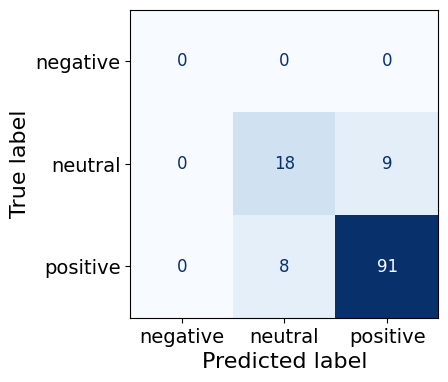

In [76]:
#Confusion Matrix
def make_cm(df):
    """Create confusion matrix for true vs predicted sentiment classes"""

    cm = confusion_matrix(y_true=df['label_text'], y_pred=df['pred_text'], labels=['negative', 'neutral', 'positive'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['negative', 'neutral', 'positive'])

    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax,text_kw={'fontsize': 12}, cmap='Blues', colorbar=False);

    # change label font size without changing label text
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)

    # make tick labels larger
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)

make_cm(test_df)

In [79]:
def get_prediction(model, text, tokz):
  device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

  model = model.to(device)

  inputs = tokz(text, return_tensors="pt",truncation=True, padding=True)

  inputs= {k:v.to(device) for k,v in inputs.items()}

  model.eval()

  with torch.no_grad():
    outputs = model(**inputs)

  logits = outputs.logits.detach().cpu()
  probs = torch.softmax(logits,dim=-1)
  p_class = torch.argmax(probs,dim=-1).item()

  p = probs[0][p_class].item()

  labels = {0:"negative",1:"neutral",2:"positive"}

  print(f"Probability: {p:.2f}")
  print(f"Predicted label: {labels[p_class]}")
  return p_class, p

In [87]:
text = "The net sales went down from USD $8.9M to USD $1.2M since the same quarter last year"

_ = get_prediction(model, text, tokz)

Probability: 0.79
Predicted label: negative


In [88]:
text = "The net sales went up from USD $3.4M to USD $5.6M since the same quarter last year"

_ = get_prediction(model, text, tokz)

Probability: 0.98
Predicted label: positive


In [89]:
#Grid Search to find best learning rate

In [91]:
def get_trainer(lr, bs = 16):
  args = TrainingArguments(
      "outputs",
      learning_rate=lr,
      warmup_ratio=0.1,
      lr_scheduler_type="cosine",
      fp16=True,
      eval_strategy="epoch",
      logging_strategy='epoch',
      per_device_train_batch_size=bs,
      per_device_eval_batch_size=bs*2,
      num_train_epochs=3,
      weight_decay=0.01,
      report_to='none'
  )
  model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=3)
  model.resize_token_embeddings(len(tokz))
  model.config.pad_token_id = model.config.eos_token_id

  trainer = Trainer(model, args, train_dataset=train_ds,eval_dataset=eval_ds,
                    tokenizer=tokz, compute_metrics=get_acc, callbacks=[metric_callback])

  return trainer,args

In [92]:
metrics = []
trainers = []
learning_rates = [1e-6, 1e-5, 3e-5, 5e-5, 8e-5, 1e-4, 3e-4, 5e-4, 8e-4, 1e-3, 1e-2, 1e-1]
#padding  = [LEFT, RIGHT]
# BATCH_SIZE = [8,16,24,32]
#8*2*4 = 64

#learning_rates = [8e-5]

for lr in learning_rates:
    print(f"Learning Rate: {lr}")

    metric_callback = MetricCallback()

    trainer, args = get_trainer(lr, bs=64)

    trainer.train()

    metrics.append({
        "learning_rate": lr,
        "metrics": metric_callback.metrics
        })

    trainers.append(trainer)

    # clean up
    report_gpu()
    report_gpu()
    !rm -r /kaggle/working/outputs

Learning Rate: 1e-06


/tmp/ipython-input-399906726.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=train_ds,eval_dataset=eval_ds,


{'loss': 1.4496, 'grad_norm': 64.89244842529297, 'learning_rate': 8.802029828000155e-07, 'epoch': 1.0}
{'eval_loss': 1.1232857704162598, 'eval_accuracy': 0.4780701696872711, 'eval_runtime': 0.3144, 'eval_samples_per_second': 725.127, 'eval_steps_per_second': 6.361, 'epoch': 1.0}
{'loss': 1.0164, 'grad_norm': 78.32344818115234, 'learning_rate': 3.454915028125263e-07, 'epoch': 2.0}
{'eval_loss': 1.0460190773010254, 'eval_accuracy': 0.5921052694320679, 'eval_runtime': 0.3205, 'eval_samples_per_second': 711.466, 'eval_steps_per_second': 6.241, 'epoch': 2.0}
{'loss': 0.9186, 'grad_norm': 58.208003997802734, 'learning_rate': 1.541333133436018e-09, 'epoch': 3.0}
{'eval_loss': 1.035921335220337, 'eval_accuracy': 0.5877193212509155, 'eval_runtime': 0.3661, 'eval_samples_per_second': 622.831, 'eval_steps_per_second': 5.463, 'epoch': 3.0}
{'train_runtime': 23.123, 'train_samples_per_second': 118.064, 'train_steps_per_second': 1.946, 'train_loss': 1.1281858020358615, 'epoch': 3.0}
GPU:0
process   

/tmp/ipython-input-399906726.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=train_ds,eval_dataset=eval_ds,


{'loss': 1.3333, 'grad_norm': 63.467628479003906, 'learning_rate': 8.802029828000157e-06, 'epoch': 1.0}
{'eval_loss': 0.9168729186058044, 'eval_accuracy': 0.5701754093170166, 'eval_runtime': 0.3183, 'eval_samples_per_second': 716.306, 'eval_steps_per_second': 6.283, 'epoch': 1.0}
{'loss': 0.4836, 'grad_norm': 32.13288116455078, 'learning_rate': 3.4549150281252635e-06, 'epoch': 2.0}
{'eval_loss': 0.7764169573783875, 'eval_accuracy': 0.6929824352264404, 'eval_runtime': 0.3557, 'eval_samples_per_second': 640.904, 'eval_steps_per_second': 5.622, 'epoch': 2.0}
{'loss': 0.2632, 'grad_norm': 16.313413619995117, 'learning_rate': 1.541333133436018e-08, 'epoch': 3.0}
{'eval_loss': 0.7713589072227478, 'eval_accuracy': 0.6885964870452881, 'eval_runtime': 0.3822, 'eval_samples_per_second': 596.55, 'eval_steps_per_second': 5.233, 'epoch': 3.0}
{'train_runtime': 14.3227, 'train_samples_per_second': 190.606, 'train_steps_per_second': 3.142, 'train_loss': 0.6933600266774496, 'epoch': 3.0}
GPU:0
process

/tmp/ipython-input-399906726.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=train_ds,eval_dataset=eval_ds,


{'loss': 1.1832, 'grad_norm': 36.30455780029297, 'learning_rate': 2.6406089484000465e-05, 'epoch': 1.0}
{'eval_loss': 0.7329518795013428, 'eval_accuracy': 0.6842105388641357, 'eval_runtime': 0.321, 'eval_samples_per_second': 710.261, 'eval_steps_per_second': 6.23, 'epoch': 1.0}
{'loss': 0.2871, 'grad_norm': 30.443605422973633, 'learning_rate': 1.036474508437579e-05, 'epoch': 2.0}
{'eval_loss': 0.6859974265098572, 'eval_accuracy': 0.7324561476707458, 'eval_runtime': 0.3187, 'eval_samples_per_second': 715.387, 'eval_steps_per_second': 6.275, 'epoch': 2.0}
{'loss': 0.047, 'grad_norm': 1.6443175077438354, 'learning_rate': 4.623999400308054e-08, 'epoch': 3.0}
{'eval_loss': 0.7030487656593323, 'eval_accuracy': 0.7105262875556946, 'eval_runtime': 0.3768, 'eval_samples_per_second': 605.069, 'eval_steps_per_second': 5.308, 'epoch': 3.0}
{'train_runtime': 22.7516, 'train_samples_per_second': 119.992, 'train_steps_per_second': 1.978, 'train_loss': 0.5057732118500604, 'epoch': 3.0}
GPU:0
process  

/tmp/ipython-input-399906726.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=train_ds,eval_dataset=eval_ds,


{'loss': 1.2196, 'grad_norm': 24.473913192749023, 'learning_rate': 4.401014914000078e-05, 'epoch': 1.0}
{'eval_loss': 0.8406270146369934, 'eval_accuracy': 0.6622806787490845, 'eval_runtime': 0.3133, 'eval_samples_per_second': 727.661, 'eval_steps_per_second': 6.383, 'epoch': 1.0}
{'loss': 0.3265, 'grad_norm': 24.90828514099121, 'learning_rate': 1.7274575140626318e-05, 'epoch': 2.0}
{'eval_loss': 0.641045868396759, 'eval_accuracy': 0.75, 'eval_runtime': 0.3147, 'eval_samples_per_second': 724.565, 'eval_steps_per_second': 6.356, 'epoch': 2.0}
{'loss': 0.0494, 'grad_norm': 4.6871819496154785, 'learning_rate': 7.706665667180091e-08, 'epoch': 3.0}
{'eval_loss': 0.7090164422988892, 'eval_accuracy': 0.7631579041481018, 'eval_runtime': 0.383, 'eval_samples_per_second': 595.317, 'eval_steps_per_second': 5.222, 'epoch': 3.0}
{'train_runtime': 14.1367, 'train_samples_per_second': 193.114, 'train_steps_per_second': 3.183, 'train_loss': 0.5318435099389818, 'epoch': 3.0}
GPU:0
process      13512 use

/tmp/ipython-input-399906726.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=train_ds,eval_dataset=eval_ds,


{'loss': 1.3049, 'grad_norm': 16.783493041992188, 'learning_rate': 7.041623862400125e-05, 'epoch': 1.0}
{'eval_loss': 0.772412896156311, 'eval_accuracy': 0.6622806787490845, 'eval_runtime': 0.3172, 'eval_samples_per_second': 718.861, 'eval_steps_per_second': 6.306, 'epoch': 1.0}
{'loss': 0.3957, 'grad_norm': 15.202868461608887, 'learning_rate': 2.7639320225002108e-05, 'epoch': 2.0}
{'eval_loss': 0.5828443765640259, 'eval_accuracy': 0.7587719559669495, 'eval_runtime': 0.318, 'eval_samples_per_second': 716.897, 'eval_steps_per_second': 6.289, 'epoch': 2.0}
{'loss': 0.0683, 'grad_norm': 2.860386848449707, 'learning_rate': 1.2330665067488145e-07, 'epoch': 3.0}
{'eval_loss': 0.6195181608200073, 'eval_accuracy': 0.7763158082962036, 'eval_runtime': 0.363, 'eval_samples_per_second': 628.092, 'eval_steps_per_second': 5.51, 'epoch': 3.0}
{'train_runtime': 14.1572, 'train_samples_per_second': 192.835, 'train_steps_per_second': 3.179, 'train_loss': 0.5896267652511596, 'epoch': 3.0}
GPU:0
process  

/tmp/ipython-input-399906726.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=train_ds,eval_dataset=eval_ds,


{'loss': 1.3463, 'grad_norm': 12.589303016662598, 'learning_rate': 8.802029828000156e-05, 'epoch': 1.0}
{'eval_loss': 0.634007453918457, 'eval_accuracy': 0.7587719559669495, 'eval_runtime': 0.3149, 'eval_samples_per_second': 724.125, 'eval_steps_per_second': 6.352, 'epoch': 1.0}
{'loss': 0.3986, 'grad_norm': 18.370140075683594, 'learning_rate': 3.4549150281252636e-05, 'epoch': 2.0}
{'eval_loss': 0.5524793863296509, 'eval_accuracy': 0.780701756477356, 'eval_runtime': 0.3168, 'eval_samples_per_second': 719.776, 'eval_steps_per_second': 6.314, 'epoch': 2.0}
{'loss': 0.0524, 'grad_norm': 1.7387146949768066, 'learning_rate': 1.5413331334360182e-07, 'epoch': 3.0}
{'eval_loss': 0.5592310428619385, 'eval_accuracy': 0.7938596606254578, 'eval_runtime': 0.374, 'eval_samples_per_second': 609.581, 'eval_steps_per_second': 5.347, 'epoch': 3.0}
{'train_runtime': 16.3239, 'train_samples_per_second': 167.24, 'train_steps_per_second': 2.757, 'train_loss': 0.5990864713986714, 'epoch': 3.0}
GPU:0
process 

/tmp/ipython-input-399906726.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=train_ds,eval_dataset=eval_ds,


{'loss': 1.8387, 'grad_norm': 6.449409008026123, 'learning_rate': 0.00026406089484000466, 'epoch': 1.0}
{'eval_loss': 0.6723209023475647, 'eval_accuracy': 0.7456140518188477, 'eval_runtime': 0.3159, 'eval_samples_per_second': 721.71, 'eval_steps_per_second': 6.331, 'epoch': 1.0}
{'loss': 0.571, 'grad_norm': 5.063930034637451, 'learning_rate': 0.0001036474508437579, 'epoch': 2.0}
{'eval_loss': 0.5372140407562256, 'eval_accuracy': 0.7894737124443054, 'eval_runtime': 0.3159, 'eval_samples_per_second': 721.792, 'eval_steps_per_second': 6.332, 'epoch': 2.0}
{'loss': 0.2021, 'grad_norm': 1.9928700923919678, 'learning_rate': 4.623999400308054e-07, 'epoch': 3.0}
{'eval_loss': 0.48486360907554626, 'eval_accuracy': 0.8245614171028137, 'eval_runtime': 0.3947, 'eval_samples_per_second': 577.709, 'eval_steps_per_second': 5.068, 'epoch': 3.0}
{'train_runtime': 18.7957, 'train_samples_per_second': 145.246, 'train_steps_per_second': 2.394, 'train_loss': 0.8706015268961589, 'epoch': 3.0}
GPU:0
process 

/tmp/ipython-input-399906726.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=train_ds,eval_dataset=eval_ds,


{'loss': 2.4689, 'grad_norm': 5.593011379241943, 'learning_rate': 0.0004401014914000078, 'epoch': 1.0}
{'eval_loss': 0.8997716903686523, 'eval_accuracy': 0.5833333134651184, 'eval_runtime': 0.3249, 'eval_samples_per_second': 701.815, 'eval_steps_per_second': 6.156, 'epoch': 1.0}
{'loss': 0.7708, 'grad_norm': 9.566587448120117, 'learning_rate': 0.00017274575140626317, 'epoch': 2.0}
{'eval_loss': 0.6569871306419373, 'eval_accuracy': 0.7061403393745422, 'eval_runtime': 0.3594, 'eval_samples_per_second': 634.394, 'eval_steps_per_second': 5.565, 'epoch': 2.0}
{'loss': 0.4976, 'grad_norm': 2.945474147796631, 'learning_rate': 7.70666566718009e-07, 'epoch': 3.0}
{'eval_loss': 0.6234261989593506, 'eval_accuracy': 0.7368420958518982, 'eval_runtime': 0.3765, 'eval_samples_per_second': 605.588, 'eval_steps_per_second': 5.312, 'epoch': 3.0}
{'train_runtime': 16.4045, 'train_samples_per_second': 166.417, 'train_steps_per_second': 2.743, 'train_loss': 1.245783880021837, 'epoch': 3.0}
GPU:0
process   

/tmp/ipython-input-399906726.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=train_ds,eval_dataset=eval_ds,


{'loss': 3.1369, 'grad_norm': 11.853339195251465, 'learning_rate': 0.0007041623862400125, 'epoch': 1.0}
{'eval_loss': 1.6322717666625977, 'eval_accuracy': 0.5833333134651184, 'eval_runtime': 0.3148, 'eval_samples_per_second': 724.325, 'eval_steps_per_second': 6.354, 'epoch': 1.0}
{'loss': 1.0903, 'grad_norm': 9.398693084716797, 'learning_rate': 0.0002763932022500211, 'epoch': 2.0}
{'eval_loss': 0.8328139781951904, 'eval_accuracy': 0.5833333134651184, 'eval_runtime': 0.3164, 'eval_samples_per_second': 720.593, 'eval_steps_per_second': 6.321, 'epoch': 2.0}
{'loss': 0.6997, 'grad_norm': 2.3932130336761475, 'learning_rate': 1.2330665067488145e-06, 'epoch': 3.0}
{'eval_loss': 0.6981450915336609, 'eval_accuracy': 0.7324561476707458, 'eval_runtime': 0.3692, 'eval_samples_per_second': 617.479, 'eval_steps_per_second': 5.416, 'epoch': 3.0}
{'train_runtime': 14.5213, 'train_samples_per_second': 188.0, 'train_steps_per_second': 3.099, 'train_loss': 1.6422918955485026, 'epoch': 3.0}
GPU:0
process 

/tmp/ipython-input-399906726.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=train_ds,eval_dataset=eval_ds,


{'loss': 3.7017, 'grad_norm': 49.27745819091797, 'learning_rate': 0.0008802029828000156, 'epoch': 1.0}
{'eval_loss': 2.491912364959717, 'eval_accuracy': 0.1184210553765297, 'eval_runtime': 0.3165, 'eval_samples_per_second': 720.477, 'eval_steps_per_second': 6.32, 'epoch': 1.0}
{'loss': 1.1383, 'grad_norm': 10.231348991394043, 'learning_rate': 0.00034549150281252633, 'epoch': 2.0}
{'eval_loss': 0.8228524327278137, 'eval_accuracy': 0.6184210777282715, 'eval_runtime': 0.354, 'eval_samples_per_second': 644.134, 'eval_steps_per_second': 5.65, 'epoch': 2.0}
{'loss': 0.7866, 'grad_norm': 6.38649845123291, 'learning_rate': 1.541333133436018e-06, 'epoch': 3.0}
{'eval_loss': 0.7896345853805542, 'eval_accuracy': 0.6622806787490845, 'eval_runtime': 0.409, 'eval_samples_per_second': 557.476, 'eval_steps_per_second': 4.89, 'epoch': 3.0}
{'train_runtime': 19.1923, 'train_samples_per_second': 142.245, 'train_steps_per_second': 2.345, 'train_loss': 1.8755495495266385, 'epoch': 3.0}
GPU:0
process      1

/tmp/ipython-input-399906726.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=train_ds,eval_dataset=eval_ds,


{'loss': 5.0044, 'grad_norm': 26.283767700195312, 'learning_rate': 0.008802029828000156, 'epoch': 1.0}
{'eval_loss': 1.4672935009002686, 'eval_accuracy': 0.5833333134651184, 'eval_runtime': 0.3117, 'eval_samples_per_second': 731.526, 'eval_steps_per_second': 6.417, 'epoch': 1.0}
{'loss': 3.3937, 'grad_norm': 41.41870880126953, 'learning_rate': 0.003454915028125263, 'epoch': 2.0}
{'eval_loss': 2.3478853702545166, 'eval_accuracy': 0.2982456088066101, 'eval_runtime': 0.3534, 'eval_samples_per_second': 645.143, 'eval_steps_per_second': 5.659, 'epoch': 2.0}
{'loss': 1.2919, 'grad_norm': 27.88524627685547, 'learning_rate': 1.541333133436018e-05, 'epoch': 3.0}
{'eval_loss': 1.0519013404846191, 'eval_accuracy': 0.3114035129547119, 'eval_runtime': 0.3855, 'eval_samples_per_second': 591.396, 'eval_steps_per_second': 5.188, 'epoch': 3.0}
{'train_runtime': 17.9627, 'train_samples_per_second': 151.981, 'train_steps_per_second': 2.505, 'train_loss': 3.229975340101454, 'epoch': 3.0}
GPU:0
process    

/tmp/ipython-input-399906726.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model, args, train_dataset=train_ds,eval_dataset=eval_ds,


{'loss': 21.6313, 'grad_norm': nan, 'learning_rate': 0.08802029828000156, 'epoch': 1.0}
{'eval_loss': nan, 'eval_accuracy': 0.2719298303127289, 'eval_runtime': 0.3119, 'eval_samples_per_second': 730.892, 'eval_steps_per_second': 6.411, 'epoch': 1.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.03454915028125263, 'epoch': 2.0}
{'eval_loss': nan, 'eval_accuracy': 0.2719298303127289, 'eval_runtime': 0.3114, 'eval_samples_per_second': 732.149, 'eval_steps_per_second': 6.422, 'epoch': 2.0}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 0.0001541333133436018, 'epoch': 3.0}
{'eval_loss': nan, 'eval_accuracy': 0.2719298303127289, 'eval_runtime': 0.4098, 'eval_samples_per_second': 556.422, 'eval_steps_per_second': 4.881, 'epoch': 3.0}
{'train_runtime': 33.5811, 'train_samples_per_second': 81.296, 'train_steps_per_second': 1.34, 'train_loss': 7.210416666666666, 'epoch': 3.0}
GPU:0
process      13512 uses    14354.000 MB GPU memory
GPU:0
process      13512 uses    10792.000 MB GPU memory


In [94]:
def results_to_dataframe(results, model_name):
    rows = []
    for result in results:
        initial_lr = result['learning_rate']
        for metric in result['metrics']:
            row = {
                'model_name': model_name,
                'initial_learning_rate': initial_lr,
                'current_learning_rate': metric.get('learning_rate'),
            }
            row.update(metric)
            rows.append(row)

    df = pd.DataFrame(rows)

    # Ensure specific columns are at the beginning
    first_columns = ['model_name', 'initial_learning_rate', 'current_learning_rate', 'epoch']
    other_columns = [col for col in df.columns if col not in first_columns]
    df = df[first_columns + other_columns]

    return df

In [96]:
#Evaluating GRID testing results
metrics_df = results_to_dataframe(metrics, model_name="TinyStoried-33M")
metrics_df = metrics_df.query("current_learning_rate.notna()")

In [97]:
metrics_df

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
1,TinyStoried-33M,0.000001,8.802030e-07,1.0,8.802030e-07,1.4496,64.892448,1.123286,0.478070,0.3144,725.127,6.361,NaN,NaN,NaN,NaN,NaN
2,TinyStoried-33M,0.000001,3.454915e-07,2.0,3.454915e-07,1.0164,78.323448,1.046019,0.592105,0.3205,711.466,6.241,NaN,NaN,NaN,NaN,NaN
3,TinyStoried-33M,0.000001,1.541333e-09,3.0,1.541333e-09,0.9186,58.208004,1.035921,0.587719,0.3661,622.831,5.463,23.1230,118.064,1.946,6.082452e+13,1.128186
5,TinyStoried-33M,0.000010,8.802030e-06,1.0,8.802030e-06,1.3333,63.467628,0.916873,0.570175,0.3183,716.306,6.283,NaN,NaN,NaN,NaN,NaN
6,TinyStoried-33M,0.000010,3.454915e-06,2.0,3.454915e-06,0.4836,32.132881,0.776417,0.692982,0.3557,640.904,5.622,NaN,NaN,NaN,NaN,NaN
7,TinyStoried-33M,0.000010,1.541333e-08,3.0,1.541333e-08,0.2632,16.313414,0.771359,0.688596,0.3822,596.550,5.233,14.3227,190.606,3.142,6.082452e+13,0.693360
9,TinyStoried-33M,0.000030,2.640609e-05,1.0,2.640609e-05,1.1832,36.304558,0.732952,0.684211,0.3210,710.261,6.230,NaN,NaN,NaN,NaN,NaN
10,TinyStoried-33M,0.000030,1.036475e-05,2.0,1.036475e-05,0.2871,30.443605,0.685997,0.732456,0.3187,715.387,6.275,NaN,NaN,NaN,NaN,NaN
11,TinyStoried-33M,0.000030,4.623999e-08,3.0,4.623999e-08,0.0470,1.644318,0.703049,0.710526,0.3768,605.069,5.308,22.7516,119.992,1.978,6.082452e+13,0.505773
13,TinyStoried-33M,0.000050,4.401015e-05,1.0,4.401015e-05,1.2196,24.473913,0.840627,0.662281,0.3133,727.661,6.383,NaN,NaN,NaN,NaN,NaN


In [100]:
metrics_df.query("eval_accuracy == eval_accuracy.max()")

,model_name,initial_learning_rate,current_learning_rate,epoch,learning_rate,loss,grad_norm,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
27,TinyStoried-33M,0.0003,4.623999e-07,3.0,4.623999e-07,0.2021,1.99287,0.484864,0.824561,0.3947,577.709,5.068,18.7957,145.246,2.394,6.082452e+13,0.870602


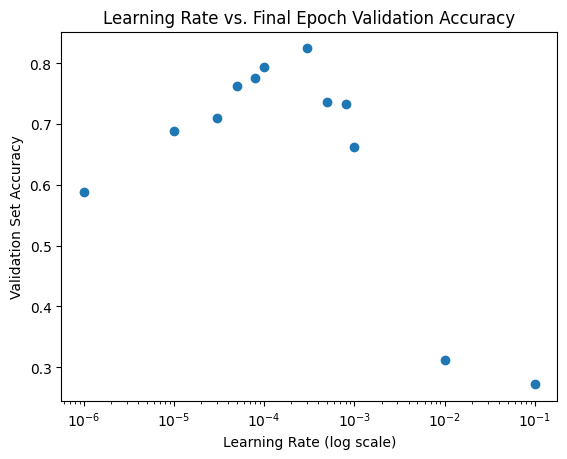

In [112]:
final_epoch_metrics = metrics_df.query("epoch == 3")
plt.scatter(final_epoch_metrics['initial_learning_rate'],final_epoch_metrics['eval_accuracy'])
plt.xscale("log")
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Validation Set Accuracy')
plt.title('Learning Rate vs. Final Epoch Validation Accuracy');